<font color='blue'> **24_Vilhelmsen LGR** </font> 

In [20]:
import os ; import pandas as pd ; import numpy as np ;  import matplotlib.pyplot as plt ; from pathlib import Path  ; import flopy 
from modflow_devtools.misc import get_env, timed ; write=get_env("WRITE", True);run=get_env("RUN", True) 
sim_ws    = Path("./24_LGR")                         ; sim_ws.mkdir(exist_ok=True)     ; sim_name = example_name = "ex-gwf-lgrv"
exe_name  = 'E:\\15_REPOS\\00_BETAMI\\bin\\mf6.exe'  ; workspace = figs_path = sim_ws       

In [21]:
length_units = "meters" ; time_units = "seconds"    ; k11_str = "5.e-07, 1.e-06, 5.e-05" ; nouter = 50 ; ninner = 100 ; hclose = 1e-6 ; rclose = 100.0
nper = 1 ;nlay = 25 ;nrow = 183 ;ncol = 147         ; nlaygc = 9 ;nrowcg = 61 ;ncolcg = 49 ;delr = 35 ;delc = 25 ;delv = 5   # ;delrgc = 105 
delcgc = 75 ;delvgc = 15 ; top_str = "variable"     ; botm_str = "30 to -90" ; icelltype = 0 ; recharge = 0.0000000011098 ;
parameters = {"ex-gwf-lgrv-lgr": {"configuration": "LGR"}}

In [22]:
path = 'E:\\15_REPOS\\00_BETAMI\\bin\\data_modflow6-examples\\ex-gwf-lgrv'                 ; top = np.loadtxt(os.path.join(path,"top.dat"))
dt = [("k",int),("i",int),("j",int) ,("stage",float),("conductance",float),("rbot",float)] ; rivdat=np.loadtxt(os.path.join(path,"riv.dat"), dtype=dt)
ikzone = np.empty((nlay, nrow, ncol),dtype=float)
for k in range(nlay):                        
    fname = f"ikzone{k + 1}.dat"    ;f_ikzone = os.path.join(path, fname)                   ; ikzone[k, :, :] = np.loadtxt(f_ikzone)
a1 = pd.DataFrame(top)    ; a1.to_csv (sim_ws/ "01_top.csv")                    ; a1 = pd.DataFrame(rivdat)    ; a1.to_csv (sim_ws/ "02a_rivdat0.csv")
a1 = pd.DataFrame(ikzone[24,:,:]) ; a1.to_csv (sim_ws/ "03_ikzone_xy.csv")                 

In [23]:
perlen = [1.0]    ; nstp = [1] ; tsmult = [1.0]                 ; tdis_ds = list(zip(perlen, nstp, tsmult))
rivdat["k"] -= 1  ; rivdat["i"] -= 1  ; rivdat["j"] -= 1        ; riv_spd0= [[(k, i, j), stage, cond, rbot] for k, i, j, stage, cond, rbot in rivdat]
botm = [30 - k * delv for k in range(nlay)]                     ; botm = np.array(botm)
k11_values = [float(value) for value in k11_str.split(",")]     ; k11 = np.zeros((nlay, nrow, ncol), dtype=float)
for i, kval in enumerate(k11_values):                             k11 = np.where(ikzone == i + 1, kval, k11)
xmin = 0.0 ; xmax = ncol * delr          ; ymin = 0.0 ; ymax = nrow * delc   ; parent_domain = [xmin, xmax, ymin, ymax]
child_domain = [xmin + 15 * 3 * delr     , xmin + 41 * 3 * delr              , ymax - 49 * 3 * delc,ymax - 19 * 3 * delc]    # child_domain
print('parent_domain', parent_domain, '   child', child_domain, "    layers",len(botm) ,        '        riv_spd_0|3 = 02_riv.csv')

parent_domain [0.0, 5145, 0.0, 4575]    child [1575.0, 4305.0, 900, 3150]     layers 25         riv_spd_0|3 = 02_riv.csv


In [24]:
ncppl = [1, 3, 3, 3, 3, 3, 3, 3, 3]                          ; nlayc = len(ncppl)           ; blay_index = [ncppl[0] - 1]  
idomainp = np.ones((nlay , nrow , ncol ), dtype=int)         ; xorigin = xmin               ; yorigin = ymin 
print('ikzone       ', ikzone.shape , '           nlayc',nlayc,         '          blay_index', blay_index, '    k11_shape',k11.shape)

ikzone        (25, 183, 147)            nlayc 9           blay_index [0]     k11_shape (25, 183, 147)


In [25]:
def coarsen_shape(icoarsen, nrow, ncol):
    nrowc = int(np.ceil(nrow / icoarsen))   ; ncolc = int(np.ceil(ncol / icoarsen)) ;    return (nrowc, ncolc)
def create_resampling_labels(a, icoarsen):
    nrow, ncol = a.shape                    ; labels = np.zeros((nrow, ncol), dtype=int) ;     nodec = 0
    for ic in range(0, nrow, icoarsen):
        for jc in range(0, ncol, icoarsen):
            labels[ic : ic + icoarsen, jc : jc + icoarsen] = nodec          ; nodec += 1
    return labels
def array_resampler(aaa, icoarsen, method):  
    import scipy.ndimage as ndimage
    assert method in ["mean", "minimum", "maximum", "sum"]
    nrow, ncol = aaa.shape
    nrowc, ncolc = coarsen_shape(icoarsen, nrow, ncol)  ; labels = create_resampling_labels(aaa, icoarsen) ;  idx = np.array(range(nrowc * ncolc))
    if method   == "mean":      ar = ndimage.mean    (aaa, labels=labels, index=idx)
    elif method == "minimum":   ar = ndimage.minimum (aaa, labels=labels, index=idx)
    elif method == "maximum":   ar = ndimage.maximum (aaa, labels=labels, index=idx)
    elif method == "sum":       ar = ndimage.sum     (aaa, labels=labels, index=idx)
    return ar.reshape((nrowc, ncolc))
stage_grid1 = np.zeros((nrow, ncol), dtype=float)               ; cond_grid1 = np.zeros((nrow, ncol), dtype=float)
rbot_grid1  = np.zeros((nrow, ncol), dtype=float)               ; count_grid1 = np.zeros((nrow, ncol), dtype=int)       ;   icoarsen = 3
for k, i, j, stage, cond, rbot in rivdat:
    stage_grid1[i, j] = stage   ; cond_grid1[i, j] = cond       ; rbot_grid1[i, j] = rbot            ; count_grid1[i, j] += 1
print('stage_grid1, cond_grid1, rbot_grid1, count_grid1      ', stage_grid1[i, j], cond_grid1[i, j], rbot_grid1[i, j], count_grid1[i, j])

stage_grid1, cond_grid1, rbot_grid1, count_grid1       50.981 0.01837 50.481 1


In [26]:
def riv_resample(icoarsen, nrow, ncol, rivdat, idomain, rowcolspan):
    stage_grid = np.zeros((nrow, ncol), dtype=float)             ; cond_grid = np.zeros((nrow, ncol), dtype=float)
    rbot_grid  = np.zeros((nrow, ncol), dtype=float)             ; count_grid = np.zeros((nrow, ncol), dtype=int)
    for k, i, j, stage, cond, rbot in rivdat:
        stage_grid[i, j] = stage   ; cond_grid[i, j] = cond       ; rbot_grid[i, j] = rbot            ; count_grid[i, j] += 1
    stagec_grid                      = array_resampler  (stage_grid, icoarsen, "sum")  ; condc_grid  = array_resampler  (cond_grid, icoarsen, "sum")
    rbotc_grid                       = array_resampler  (rbot_grid , icoarsen, "sum")  ; countc_grid = array_resampler  (count_grid, icoarsen, "sum")
    stagec_grid = np.divide(stagec_grid, countc_grid)  ; rbotc_grid  = np.divide(rbotc_grid, countc_grid)
    if rowcolspan is not None: 
        istart, istop, jstart, jstop = rowcolspan               
        stagec_grid                  = stagec_grid [istart:istop, jstart:jstop]        ; condc_grid  = condc_grid   [istart:istop, jstart:jstop]     
        rbotc_grid                   = rbotc_grid  [istart:istop, jstart:jstop]        ; countc_grid = countc_grid  [istart:istop, jstart:jstop]
    rows, cols = np.where(condc_grid > 0.0)                     ;  rivdatc = []
    for i, j in zip(rows, cols): 
        k = 0
        if idomain[k, i, j] == 1:             rivdatc.append([(k, i, j), stagec_grid[i, j], condc_grid[i, j], rbotc_grid[i, j]])
    return rivdatc

In [27]:
modelname1 = 'parent' ; icoarsen = 3 ; ncppl = [1,3,3,3,3,3,3,3,3]    ; xmin1,xmax1,ymin1,ymax1=parent_domain ; xmin2,xmax2,ymin2,ymax2=child_domain
delc1 = delc * icoarsen                                  ; istart = int((ymax1 - ymax2) / delc1)      ; istop = int((ymax2 - ymin1) / delc1)      
delr1 = delr * icoarsen                                  ; jstart = int((xmin2 - xmin1) / delr1)      ; jstop = int((xmax1 - xmin2) / delr1)     
nrow1,ncol1=coarsen_shape(icoarsen, nrow, ncol)     ;top1=array_resampler(top,icoarsen,"mean");a1=pd.DataFrame(top1);a1.to_csv(sim_ws/"01b_top.csv")
nlay1 = len(ncppl) ;idomain1=np.ones((nlay1,nrow1,ncol1), dtype=int)  ; idomain1[:, istart:istop, jstart:jstop] = 0
print('PARENT   delr',delr1,'x delc' ,delc1,  'top_61x49 ' , 'idomain1', idomain1[0].shape) # print ___

modelname2 = 'child' ; icoarsen = 1                                  ; xmin1,xmax1,ymin1,ymax1=parent_domain   ;xmin2,xmax2,ymin2,ymax2=child_domain
delc1 = delc * icoarsen                                  ; istart = int((ymax1 - ymax2) / delc1)   ; istop = int((ymax1 - ymin2) / delc1)
delr1 = delr * icoarsen                                  ; jstart = int((xmin2 - xmin1) / delr1)   ; jstop = int((xmax2 - xmin1) / delr1)                           
nrow0,ncol0=coarsen_shape(icoarsen, nrow, ncol)          ; print('idomain0 =',nrow0, ncol0 , 'idomain2 =', -istart+ istop , -jstart + jstop)


PARENT   delr 105 x delc 75 top_61x49  idomain1 (61, 49)
idomain0 = 183 147 idomain2 = 90 78


In [28]:
def child_grid(sim, name):
    icoarsen = 1                                             ; xmin1,xmax1,ymin1,ymax1=parent_domain   ;xmin2,xmax2,ymin2,ymax2=child_domain
    delc1 = delc * icoarsen                                  ; istart = int((ymax1 - ymax2) / delc1)   ; istop = int((ymax1 - ymin2) / delc1)
    delr1 = delr * icoarsen                                  ; jstart = int((xmin2 - xmin1) / delr1)   ; jstop = int((xmax2 - xmin1) / delr1)
    sim = build_child(name,rowcolspan=[istart, istop, jstart, jstop],sim=sim,modelname="child",xorigin=xmin2,yorigin=ymin2)   
    return sim
def build_child(name,icoarsen=None,ncppl=None,rowcolspan=None,idomain=None,sim=None,modelname=None,xorigin=None,yorigin=None):
    icoarsen=1
    delr2 = delr * icoarsen                              ; top2 = array_resampler(top, icoarsen, "mean")
    delc2 = delc * icoarsen                              ; istart ,istop ,jstart ,jstop = rowcolspan  ; nrow2 = istop-istart ; ncol2 = jstop-jstart
    top2  = top2[istart: istop, jstart: jstop]           ; nlay2 = nlay  ; blay_index = list(range(nlay2)) ; k11c = []
    for k in range(nlay2):  ilay = blay_index[k]   ; a = array_resampler(k11[ilay], icoarsen, "maximum")   ; k11c.append(a[istart:istop,jstart:jstop])
    strt = nlay2 * [top2]   ; head_filerecord = f"{modelname}.hds"  ; budget_filerecord = f"{modelname}.cbc"  
    gwf = flopy.mf6.ModflowGwf     (sim, modelname = modelname, save_flows=True)        
    if idomain is None: idomain = 1
    flopy.mf6.ModflowGwfdis  (gwf , length_units=length_units,nlay=nlay2,nrow=nrow2,ncol=ncol2,
                              delr = delr2,delc=delc2,top=top2,botm=botm[blay_index],idomain=idomain,xorigin=xorigin,yorigin=yorigin)    
    flopy.mf6.ModflowGwfnpf  (gwf , k33overk=True,icelltype=icelltype,k=k11c,save_specific_discharge=True,k33=1.0)
    flopy.mf6.ModflowGwfic (gwf,strt=strt);i2=gwf.dis.idomain.array ;rivdat2=riv_resample(icoarsen,nrow,ncol,rivdat,i2,rowcolspan);riv_spd2={0:rivdat2}
    flopy.mf6.ModflowGwfriv  (gwf , stress_period_data=riv_spd2,pname="RIV",)
    flopy.mf6.ModflowGwfrcha (gwf , recharge=recharge, pname="RCH")
    flopy.mf6.ModflowGwfoc   (gwf , head_filerecord=head_filerecord,budget_filerecord=budget_filerecord,saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")])
    return sim

In [ ]:
def build_lgr_model(name):
    modelname1='parent'   ;icoarsen=3 ;ncppl=[1,3,3,3,3,3,3,3,3]   ;xmin1,xmax1,ymin1,ymax1=parent_domain ;xmin2,xmax2,ymin2,ymax2=child_domain
    delc1 = delc * icoarsen                                  ; istart = int((ymax1 - ymax2) / delc1)      ; istop = int((ymax2 - ymin1) / delc1)      
    delr1 = delr * icoarsen                                  ; jstart = int((xmin2 - xmin1) / delr1)      ; jstop = int((xmax1 - xmin2) / delr1) 
    nrow1, ncol1 = coarsen_shape(icoarsen, nrow, ncol)       ; top1 = array_resampler(top, icoarsen, "mean")
    nlay1 = len(ncppl) ;idomain1=np.ones((nlay1,nrow1,ncol1), dtype=int)  ; idomain1[:, istart:istop, jstart:jstop] = 0  ; blay_index=[ncppl[0]-1]
    for iln in ncppl[1:]:         last = blay_index[-1]                   ; blay_index.append(iln + last)
    strt1 = nlayc * [top1]      ; head_filerecord = f"{modelname1}.hds"   ; budget_filerecord = f"{modelname1}.cbc"   ; k11c = []
    for k in range(nlayc):        ilay = blay_index[k]     ; aa = array_resampler(k11[ilay], icoarsen, "maximum")     ; k11c.append(aa[0:nrow,0:ncol])
    
    sim = flopy.mf6.MFSimulation  (sim_name=name, sim_ws=sim_ws, exe_name="mf6")
    flopy.mf6.ModflowTdis (sim, nper=nper, perioddata=tdis_ds, time_units=time_units)
    flopy.mf6.ModflowIms  (sim,outer_maximum=nouter,outer_dvclose=hclose,inner_maximum=ninner,inner_dvclose=hclose,rcloserecord=f"{rclose} strict")
    gwf = flopy.mf6.ModflowGwf     (sim, modelname = modelname1, save_flows=True)       
    flopy.mf6.ModflowGwfdis  (gwf,length_units=length_units,nlay=nlay1,nrow=nrow1,ncol=ncol1,
                              delr=delr1,delc=delc1,top=top1,botm=botm[blay_index],idomain=idomain1 ,xorigin=xorigin,yorigin=yorigin)    
    flopy.mf6.ModflowGwfnpf  (gwf,k33overk=True,icelltype=icelltype,k=k11c,save_specific_discharge=True,k33=1.0)
    flopy.mf6.ModflowGwfic   (gwf,strt=strt1);rivdat1=riv_resample(icoarsen,nrow,ncol,rivdat,idomain1,rowcolspan=None);riv_spd1={0:rivdat1}
    flopy.mf6.ModflowGwfriv  (gwf,stress_period_data=riv_spd1,pname="RIV",)
    flopy.mf6.ModflowGwfrcha (gwf, recharge=recharge, pname="RCH")
    flopy.mf6.ModflowGwfoc   (gwf,head_filerecord=head_filerecord,budget_filerecord=budget_filerecord,saverecord=[("HEAD","ALL"),("BUDGET","ALL")])
    # _______________________________________________________________________________________________________
    sim     = child_grid (sim, name)         ; gwfc = sim.get_model("child")          ; botm1 = gwf.dis.botm.array           
    lgr     = flopy.utils.lgrutil.Lgr (nlay1 ,nrow1 ,ncol1 ,delr1 ,delc1 ,top1 ,botm1 ,idomain1 ,ncpp=icoarsen ,ncppl=ncppl)
    exgdata = lgr.get_exchange_data(angldegx=True, cdist=True)
    flopy.mf6.ModflowGwfgwf(sim ,nexg=len(exgdata) ,exgmnamea="parent" ,exgmnameb="child",exchangedata=exgdata ,auxiliary=["angldegx", "cdist"])
    return sim
def write_models(sim, silent=True): sim.write_simulation(silent=silent)
@timed
def run_models(sim, silent=False):  success, buff = sim.run_simulation(silent=silent, report=True)  ;     assert success, buff
def scenario(idx, silent=True): 
    sim = build_lgr_model('ex-gwf-lgrv-lgr')
    if write:  write_models (sim, silent=silent)
    if run:    run_models   (sim, silent=silent)
scenario(0) 

run_models took 6570.32 ms


In [30]:
sim_out  = build_lgr_model('ex-gwf-lgrv-lgr')         ; gwf_P = sim_out.get_model("parent")               ; gwf_C = sim_out.get_model("child")  
id2 = gwf_P.dis.idomain.array ; tpp  = np.ma.masked_where(id2[0] == 0, gwf_P.dis.top.array)               ; vmin = tpp.min() ; vmax = tpp.max()
tpcc = gwf_C.dis.top.array                                           ; vmin = min(vmin, tpcc.min())       ; vmax = max(vmax, tpcc.max())
irow, icol = gwf_P.modelgrid.intersect(3000.0, 3000.0)               ; kk1 = np.log(gwf_P.npf.k.array)    ; kk2 = np.log(gwf_C.npf.k.array)

layer=0 ;head32=gwf_C.output.head().get_data()  ; head32= np.ma.masked_where(head32 > 1e29, head32) ; vmin=head32[layer].min() ;
vmax=head32[layer].max()                        ; ss =np.max(head32) - np.min(head32)   ; levels=np.arange(np.min(head32[0]), np.max(head32[0]), ss/5) 

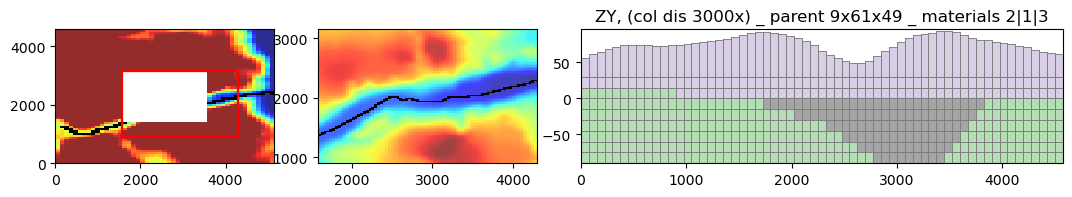

In [31]:
def beta_plot(ax):
    pmv=flopy.plot.PlotMapView(model=gwf_P, ax=ax1, layer=0)              ; cb = pmv.plot_array(tpp, cmap="jet", alpha=0.25, vmin=vmin, vmax=vmax) 
    pmv.plot_bc(name="RIV", color='black')  ; xmin, xmax, ymin, ymax = child_domain                          
    ax1.plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin], color = 'red')
    pmv = flopy.plot.PlotMapView(model=gwf_C, ax=ax2, layer=0)              ; _  = pmv.plot_array(tpcc,cmap="jet",alpha=0.2,masked_values=[1e30])    
    pmv.plot_bc(name="RIV", color='black')  #; cbar=plt.colorbar(_)
    pmv = flopy.plot.PlotCrossSection(model=gwf_P, ax=ax3, line={"column": icol})            ; pmv.plot_array(kk1, cmap="Accent", alpha=0.25)
    pmv.plot_grid(linewidth=0.5) ; ax3.set_title("ZY, (col dis 3000x) _ parent 9x61x49 _ materials 2|1|3")
    
plt.figure(figsize=(13,8))
ax1 = plt.subplot2grid((4, 4), (0, 0), colspan=1, rowspan=1)  ; ax2 = plt.subplot2grid((4, 4), (0, 1), colspan=1, rowspan=1)  
ax3 = plt.subplot2grid((4, 4), (0, 2), colspan=2, rowspan=1)  ; beta_plot(ax1) ; beta_plot(ax2) ; beta_plot(ax3)

In [32]:
sim_out  = build_lgr_model('ex-gwf-lgrv-lgr')     ; gwf_P = sim_out.get_model("parent")                 ; gwf_C = sim_out.get_model("child") 
layer=0 ;head31=gwf_P.output.head().get_data() ;head31= np.ma.masked_where(head31 > 1e29, head31) ;vmin=head31[layer].min() ;vmax=head31[layer].max()
layer=0 ;head32=gwf_C.output.head().get_data() ;head32= np.ma.masked_where(head32 > 1e29, head32) ;vmin=head32[layer].min() ;vmax=head32[layer].max()

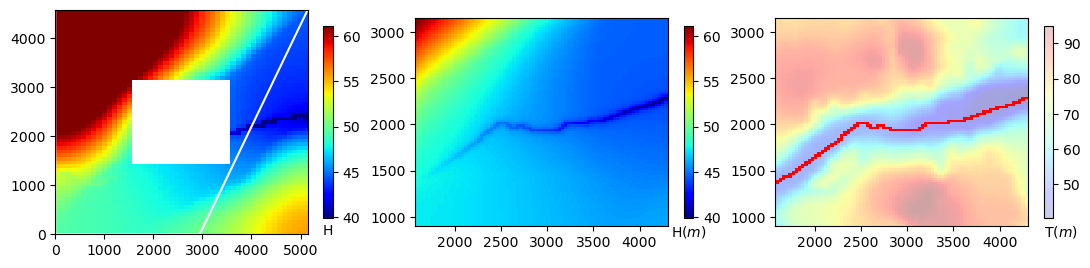

In [33]:
fig = plt.figure(figsize=(11,3))  
ax = fig.add_subplot(1, 3, 1, aspect="equal")  ; fig.tight_layout() 
pmv = flopy.plot.PlotMapView(model=gwf_P, ax=ax, layer=0) ; cb = pmv.plot_array(head31, cmap="jet", masked_values=[1e30], vmin=vmin, vmax=vmax)  
cbar=plt.colorbar(cb,shrink=0.8);cbar.ax.set_xlabel(r"H") ; ax.plot([xmin,xmax-2200,xmax,xmin,xmin],[ymin, ymin, ymax, ymax, ymin],color='white')

ax = fig.add_subplot(1, 3, 2, aspect="equal")  ; fig.tight_layout()
pmv = flopy.plot.PlotMapView(model=gwf_C, ax=ax, layer=0)  ; cb = pmv.plot_array(head32, cmap="jet", masked_values=[1e30], vmin=vmin, vmax=vmax)  
cbar = plt.colorbar(cb, shrink=0.8) ; cbar.ax.set_xlabel(r"H($m$)")       

ax = fig.add_subplot(1, 3, 3, aspect="equal")  ; fig.tight_layout()
pmv = flopy.plot.PlotMapView(model=gwf_C, ax=ax, layer=0)  ; _  = pmv.plot_array(tpcc,cmap="jet",alpha=0.2,masked_values=[1e30])    
pmv.plot_bc(name="RIV", color='red')  ; cbar=plt.colorbar(_, shrink=0.8) ; cbar.ax.set_xlabel('      T($m$)')  

plt.show()

In [34]:
from flopy.utils.postprocessing import get_water_table ; wt = get_water_table(head32)  ;     wt1 = get_water_table(head31)

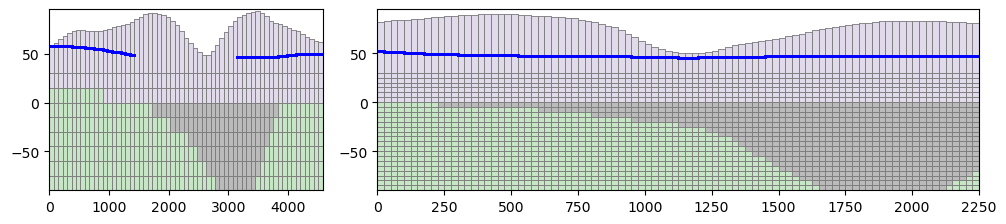

In [35]:
def beta_plot(ax):
    pmv=flopy.plot.PlotCrossSection(model=gwf_P,ax=ax1, line={"column": icol}) ;pmv.plot_array(kk1, cmap="Accent", alpha=0.25)
    pmv.plot_grid(linewidth=0.5) ; pmv.plot_surface(wt1, masked_values=[1e30], color="blue", lw=2) 
    
    pmv=flopy.plot.PlotCrossSection(model=gwf_C,ax=ax3,line={"column": icol}) 
    pmv.plot_array(kk2, cmap="Accent", alpha=0.25) ; pmv.plot_grid(linewidth=0.5) ; pmv.plot_surface(wt, masked_values=[1e30], color="blue", lw=2)

plt.figure(figsize=(12,8))
ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=1, rowspan=1)  ;   
ax3 = plt.subplot2grid((3, 3), (0, 1), colspan=2, rowspan=1)  ; beta_plot(ax1) ; beta_plot(ax3) 

In [36]:
i1=gwf_P.dis.idomain.array; print(idomain1[0].shape) ; a1=pd.DataFrame(idomain1[0]) ;a1.to_csv(sim_ws/"04_idomain_1.csv")
i2=gwf_C.dis.idomain.array; print(i2[0].shape)       ; a1=pd.DataFrame(i2[0])       ;a1.to_csv(sim_ws/"05_idomain_2.csv")

(61, 49)
(90, 78)


In [37]:
rivdat1=riv_resample(3,nrow,ncol,rivdat,idomain1,rowcolspan=None) ;a1 = pd.DataFrame(rivdat1)    ; a1.to_csv (sim_ws/ "02b_rivdat1.csv")

In [38]:
modelname2 = 'child' ; icoarsen = 1                                  ; xmin1,xmax1,ymin1,ymax1=parent_domain   ;xmin2,xmax2,ymin2,ymax2=child_domain
delc1 = delc * icoarsen                                  ; istart = int((ymax1 - ymax2) / delc1)   ; istop = int((ymax1 - ymin2) / delc1)
delr1 = delr * icoarsen                                  ; jstart = int((xmin2 - xmin1) / delr1)   ; jstop = int((xmax2 - xmin1) / delr1) 

rowcolspan = (istart, istop, jstart, jstop) 
print('rowcolspan', rowcolspan)
rivdat2=riv_resample(icoarsen,nrow,ncol,rivdat,i2,rowcolspan) ; a1 = pd.DataFrame(rivdat2)    ; a1.to_csv (sim_ws/ "02c_rivdat2.csv")

rowcolspan (57, 147, 45, 123)
